In [277]:
!pip install opencv-contrib-python opencv-python

In [278]:
dataset_dir = "/kaggle/input/alien-vs-predator-images/data"

import cv2
import os

def load_dataset_part(folder):
    result = []
    for i in os.listdir(folder):
        fn = os.path.join(folder, i)
        if os.path.isfile(fn):
            img = cv2.cvtColor(cv2.imread(fn), cv2.COLOR_BGR2GRAY)
            result.append(img)
    return result


def load_dataset(folder, train=True):
    part = 'train' if train else 'validation'
    aliens = load_dataset_part(os.path.join(folder, part, 'alien'))
    predators = load_dataset_part(os.path.join(folder, part, 'predator'))
    X = aliens + predators
    y = ['alien'] * len(aliens) + ['predator'] * len(predators)
    return X, y
    
X_train, y_train = load_dataset(os.path.join(dataset_dir))
X_test, y_test = load_dataset(os.path.join(dataset_dir), train=False)

print(f"Train size {len(X_train)}, Test size {len(X_test)}")

Train size 694, Test size 200


alien


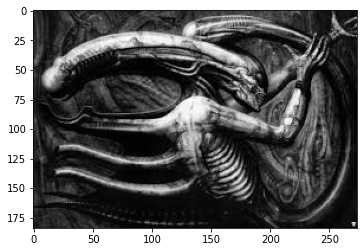

predator


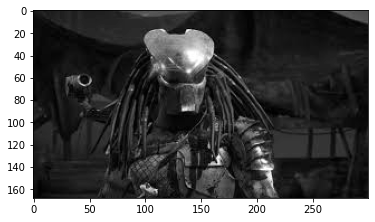

In [279]:
import matplotlib.pyplot as plt

print(y_train[13])
plt.imshow(X_train[13], cmap='gray')
plt.show()

print(y_train[-13])
plt.imshow(X_train[-13], cmap='gray')
plt.show()

2. Compute SIFT desciptors

In [280]:
# if you have a newer opencv, please use cv2.SIFT_create()
sift = cv2.SIFT_create()
X_train_sift = [sift.detectAndCompute(image, None)[1] for image in X_train]
X_test_sift = [sift.detectAndCompute(image, None)[1] for image in X_test]

In [281]:
# assert X_train_sift[13].shape == (376, 128)
# assert X_train_sift[13][0][0] == 84.0

3. Organize these vectors in the index (somehow)

In [282]:
from tqdm import tqdm
from annoy import AnnoyIndex
index = AnnoyIndex(128, 'angular')
# ...
c = 0
labels = []
for idx, des in enumerate(X_train_sift):
    for v in des:
        labels.append(idx)
        index.add_item(c, v)
        c += 1
index.build(100)

True

4. Classification

In [283]:
from collections import Counter

def clf(vecs, index, labels, classes, n=50):
    # my very simple classifier lived here. Can you do better?
    # write your code and change the method signature in needed
    c = Counter()
    for v in vecs:
        nns = index.get_nns_by_vector(v, n)
        c.update([labels[nn] for nn in nns])
#     res = sorted([(x,s) for s,x in c.most_common(n)])
    res= sorted([(x, s) for s, x in c.items()], reverse = True)
    idx = res[0][1]
    return classes[idx]

TEST


In [284]:
predictions = []
for sample in tqdm(X_test_sift):
    predictions.append(clf(sample, index, labels, y_train))

100%|██████████| 200/200 [01:02<00:00,  3.18it/s]


In [285]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

       alien       0.84      0.58      0.69       100
    predator       0.68      0.89      0.77       100

    accuracy                           0.73       200
   macro avg       0.76      0.73      0.73       200
weighted avg       0.76      0.73      0.73       200

